# Compare offline turbulence to observations
### function of wind shear and temperature gradient

In [6]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc


# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('paper')
import string
alphabet = list(string.ascii_lowercase)

# -------------------------------------------------------------------------------------------------------
# Directories
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

### Surface observations

In [3]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# Indices of simulated turbulence times (observations exist, wind > 2m/s, snow is present)
# SNQind = np.nonzero((SNQ.SP == 1).values &
#                     (SNQ.WIND > 2).values &
#                     (~(np.isnan(SNQ.SensFlux)).values |
#                     ~(np.isnan(SNQ.LatFlux)).values))
RiBulk_SNQ, _, _ = turbpy.bulkRichardson(SNQ.T6 + 273.15, SNQ.Tsrf + 273.15,SNQ.WIND, 6.)
SNQ['RiBulk'] = RiBulk_SNQ
SNQind = np.nonzero((SNQ.WIND > .2).values & (~(np.isnan(SNQ.SensFlux)).values) & (SNQ.RiBulk > 0).values)

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__2m'] = fluxObs.w_tc__2m_M
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [4]:
os.chdir(dirProj)
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov')

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
SNQ_sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
SNQ_latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
SCP_sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
SCP_sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
SCP_latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
SCP_latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

os.chdir(dirPrint)

# Temperature Gradient

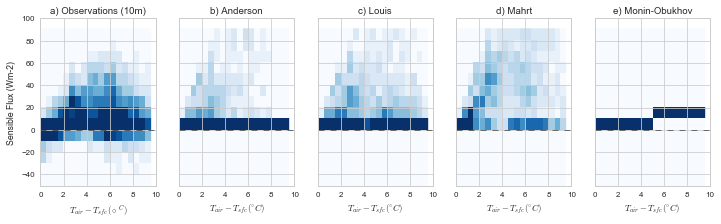

In [9]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -50
ymax = 100
xmin = 0
xmax = 10
dy = 10
dx = .5

# Format figure
cmap = kgraph.cmap_discretize(cm.Blues, 15)
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
axes = axes.flatten()

# Observed turbulence
ax = axes[0]
ax.hist2d(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], -SCP.w_tc_10m[SCPind],
          bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
          cmap=cmap, vmin=5, vmax=100)
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')
axes[0].set_ylabel('Sensible Flux (Wm-2)')

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix + 1]
    ax.hist2d(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], SCP_sensible_15m[stab].values,
              bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
              cmap=cmap, vmin=5, vmax=100)
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + ixStabilityTitles[ix])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ}C)$')
fig.savefig('OfflineTurb.SCP_15m.2dHist_TempGrad.pdf')

# -------------------------------------------------------------------------------------------------------
# SNQ
# This broke when re-running (03/10/17). The existing figure is still there. Probably something to do with not 
# indexing the data correctly. Definitely not a high priority fix.
# ymin = -50
# ymax = 100
# dy = 10
# xmin = 0
# xmax = 10
# dx = .5

# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
# axes = axes.flatten()
# # Simulated turbulence
# for ix, stab in enumerate(ixStability):
#     ax = axes[ix]
#     ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ_sensible[stab].values,
#               bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#               cmap=cmap, vmin=5, vmax=20)
#     ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
#     ax.set_title(stab)
#     ax.set_ylim(ymin, ymax)
#     ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')
# # Observed turbulence
# ax = axes[-1]
# ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ.SensFlux[SNQind],
#           bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#           cmap=cmap, vmin=5, vmax=20)
# ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
# ax.set_title('Observations (2m)')
# ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ}C)$')
# fig.savefig('OfflineTurb.SNQ.2dHist_TempGrad.pdf')


# Wind

#### Notes:
- No obvious functional relationship between observed turbulence and wind
- Assumed form of relationship between simulated turbulence and wind in the bulk aerodynamic formulas does not appear in the observations
- SNQ has the same pattern between simulations and observations

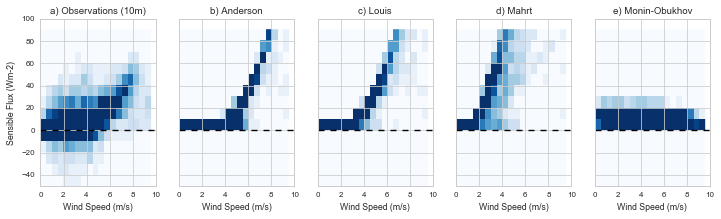

In [8]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -50
ymax = 100
xmin = 0
xmax = 10

# Figure formatting
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
axes = axes.flatten()
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Observed turbulence
ax = axes[0]
ax.hist2d(SCP.UBar_15m[SCPind], -SCP.w_tc_10m[SCPind],
          bins=(np.arange(xmin, xmax, .5), np.arange(ymin, ymax, 10)),
          cmap=cmap, vmin=5, vmax=100)
ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('Sensible Flux (Wm-2)')

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix + 1]
    ax.hist2d(SCP.UBar_15m[SCPind].values, SCP_sensible_15m[stab].values,
              bins=(np.arange(xmin, xmax, .5), np.arange(ymin, ymax, 10)),
              cmap=cmap, vmin=5, vmax=100)
    ax.plot([xmin, xmax], [0, 0], 'k--')
    ax.set_title(alphabet[ix + 1] + ') ' + ixStabilityTitles[ix])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')
fig.savefig('OfflineTurb.SCP_15m.2dHist_Shear.pdf')

# -------------------------------------------------------------------------------------------------------
# SNQ
# ymin = -50
# ymax = 100
# dy = 10
# xmin = 2
# xmax = 4
# dx = .2

# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
# axes = axes.flatten()
# # Simulated turbulence
# for ix, stab in enumerate(ixStability):
#     ax = axes[ix]
#     ax.hist2d(SNQ.WIND[SNQind], SNQ_sensible[stab].values,
#               bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#               cmap=cmap, vmin=5, vmax=20)
#     ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
#     ax.set_title(stab)
#     ax.set_ylim(ymin, ymax)
#     ax.set_xlim(xmin, xmax)
#     ax.set_xlabel('Wind Speed (m/s)')
# # Observed turbulence
# ax = axes[-1]
# ax.hist2d(SNQ.WIND[SNQind], SNQ.SensFlux[SNQind].values,
#           bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#           cmap=cmap, vmin=5, vmax=20)
# ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
# ax.set_title('Observations (2m)')
# ax.set_xlabel('Wind Speed (m/s)')
# ax.set_xlim(xmin, xmax)
# axes[0].set_ylabel('Sensible Flux (Wm-2)')
# fig.savefig('OfflineTurb.SNQ.2dHist_Shear.pdf')

# Bias by Richardson number (all)

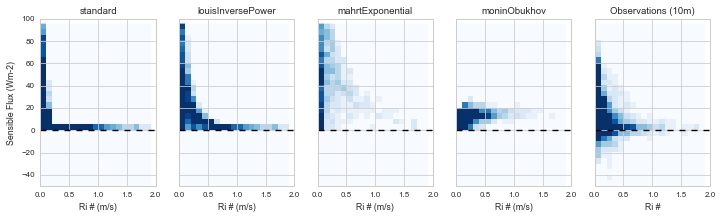

In [4]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -50
ymax = 100
dy = 5
xmin = 0
xmax = 2
dx = .1

# Figure formatting
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
axes = axes.flatten()
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.hist2d(SCP.RiBulk_15m[SCPind].values, SCP_sensible_15m[stab].values,
              bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
              cmap=cmap, vmin=5, vmax=100)
    ax.plot([xmin, xmax], [0, 0], 'k--')
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Ri # (m/s)')

# Observed turbulence
ax = axes[-1]
ax.hist2d(SCP.RiBulk_15m[SCPind], -SCP.w_tc_10m[SCPind],
          bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
          cmap=cmap, vmin=5, vmax=100)
ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_title('Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
axes[0].set_ylabel('Sensible Flux (Wm-2)')
fig.savefig('OfflineTurb.SCP_15m.2dHist_Ri.pdf')

# Bias by Richardson number

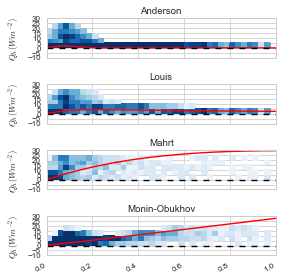

In [14]:
# -------------------------------------------------------------------------------------------------------
# Synthetic Qh set up
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

# Dictionary of colors
colr = np.append(kgraph.SRON(4), sns.color_palette(["#9b59b6"]), axis=0)
colr = dict(zip(ixStabilityTitles, colr))

# Met variables
sfcTemp = 265
airTemp = np.arange(243, 295)
windspd = 1
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk,_,_ = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

stabilitySchemes = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityTitles[0]: np.zeros_like(RiBulk),
    ixStabilityTitles[1]: np.zeros_like(RiBulk),
    ixStabilityTitles[2]: np.zeros_like(RiBulk),
    ixStabilityTitles[3]: np.zeros_like(RiBulk),
    }

# -------------------------------------------------------------------------------------------------------
# turbpy
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams,
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan


# -------------------------------------------------------------------------------------------------------
# SCP observations
# Y axis
ymin = -10
ymax = 30
dy = 5
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 55
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cm.Blues, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_15m > 0.).values & (SCP.UBar_15m < 3).values)
SCP_sensible_15m_plot = SCP_sensible_15m.reindex_like(SCP)
SCP_sensible_1m_plot = SCP_sensible_1m.reindex_like(SCP)

# Figure formatting
fig, axes = plt.subplots(4, 1, figsize=(4, 4), sharex='col', sharey='row')
axes = axes.flatten()
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Simulated turbulence
for (ix, stab), stabTitle in zip(enumerate(ixStability), ixStabilityTitles):
    ax = axes[ix]

    # Manual histogram
    X = np.concatenate((SCP.RiBulk_15m.values[SCPWindex],
                        SCP.RiBulk_2m.values[SCPWindex]), axis=0)
    Y = np.concatenate((SCP_sensible_15m_plot[stab].values[SCPWindex],
                        SCP_sensible_1m_plot[stab].values[SCPWindex]), axis=0)
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)
    
    # Synthetic turbulence
    ax.plot(RiBulk, senHeatGround[stabTitle], color='r')
    
    # Formatting
    ax.plot([xmin, xmax], [0, 0], 'k--')
    ax.set_title(stabTitle)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel('$Q_h (Wm^{-2})$')
    ax.grid()

fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_15m.2dHist_Ri.LowWind.pdf')

Lower Ri conditions = generally higher windspeed, higher Ri = lower windspeed. So all of the curves are shifted to larger Qh at low Ri and smaller Qh at high Ri. This is probably related to the unrealistic wind scaling seen in the above plots. See below for wind as a function of Ri.

I can't explain why the Anderson method doesn't go to zero at Ric = 0.2 like I expect. That's bizarre.

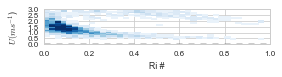

In [18]:
SCP.UBar_15m[SCPWindex].mean(dim='time')

# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = 0
ymax = 3
dy = 0.1
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 55
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cm.Blues, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_15m > 0.).values & (SCP.UBar_15m < 3).values & (SCP.UBar_2m < 3).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.2))
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Manual histogram for pcolormesh
X = np.concatenate((SCP.RiBulk_15m.values[SCPWindex],
                    SCP.RiBulk_2m.values[SCPWindex]), axis=0)
Y = np.concatenate((SCP.UBar_15m.values[SCPWindex],
                    SCP.UBar_2m.values[SCPWindex]), axis = 0)
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$U (ms^{-1}$)')
ax.grid()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_15m.2dHist_U.pdf')

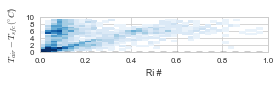

In [19]:
SCP.UBar_15m[SCPWindex].mean(dim='time')

# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = 0
ymax = 10
dy = 0.5
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 55
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cm.Blues, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_15m > 0.).values & (SCP.UBar_15m < 3).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.2))
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Manual histogram for pcolormesh
X = np.concatenate((SCP.RiBulk_15m.values[SCPWindex],
                    SCP.RiBulk_2m.values[SCPWindex]), axis=0)
Y = np.concatenate(((SCP.T_15m_M - SCP.Tsfc).values[SCPWindex],
                    (SCP.T_15m_M - SCP.Tsfc).values[SCPWindex]), axis=0)
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax)

ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$T_{air} - T_{sfc} (^{\circ} C$)')
ax.grid()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_15m.2dHist_Tgrad.pdf')

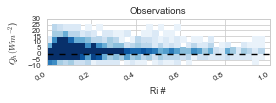

In [20]:
# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = -10
ymax = 30
dy = 5
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 55
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cm.Blues, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_15m > 0.).values & (SCP.UBar_15m < 3).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.2))
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Manual histogram for pcolormesh
X = np.concatenate((SCP.RiBulk_15m.values[SCPWindex],
                    SCP.RiBulk_2m.values[SCPWindex]), axis=0)
Y = np.concatenate((-SCP.w_tc_10m.values[SCPWindex],
                    -SCP.w_tc__2m.values[SCPWindex]), axis = 0)
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title('Observations')
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.grid()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('OfflineTurb.SCP_15m.2dHist_Ri.ObsOnly.pdf')

In [12]:
print(SCP_sensible_15m.mean(dim='time'))
print(SCP_sensible_1m.mean(dim='time'))
print(SNQ_sensible.mean(dim='time'))


<xarray.Dataset>
Dimensions:            ()
Coordinates:
    *empty*
Data variables:
    moninObukhov       float64 10.7
    standard           float64 16.19
    louisInversePower  float64 26.46
    mahrtExponential   float64 54.35
<xarray.Dataset>
Dimensions:            ()
Coordinates:
    *empty*
Data variables:
    moninObukhov       float64 8.947
    standard           float64 41.8
    louisInversePower  float64 43.93
    mahrtExponential   float64 51.82
<xarray.Dataset>
Dimensions:            ()
Coordinates:
    *empty*
Data variables:
    standard           float64 9.491
    louisInversePower  float64 21.46
    mahrtExponential   float64 54.91
    moninObukhov       float64 27.29


In [17]:
print(SNQ.SensFlux[SNQind].mean(dim='time'))
print(-SCP.w_tc_10m[SCPind].mean(dim='time'))
print(-SCP.w_tc__2m[SCPind].mean(dim='time'))

<xarray.DataArray 'SensFlux' ()>
array(6.03619084795894)
<xarray.DataArray 'w_tc_10m' ()>
array(8.77803941295555)
Coordinates:
    altitude   float64 1.645e+03
    station    |S3 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
<xarray.DataArray 'w_tc__2m' ()>
array(12.321427601635806)
Coordinates:
    altitude   float64 1.645e+03
    station    |S3 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81


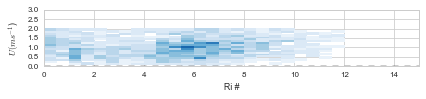

In [48]:
SCP.UBar_15m[SCPWindex].mean(dim='time')

# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = 0
ymax = 3
dy = 0.1
# X axis
xmin = 0
xmax = 15
dx = .5
# Colors
cmin = 0
cmax = 55
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cm.Blues, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_15m > 0.).values & (SCP.UBar_15m < 2).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(6, 1.5))
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Manual histogram for pcolormesh
X = np.concatenate(((SCP.T_15m_M - SCP.Tsfc).values[SCPWindex],
                    (SCP.T_15m_M - SCP.Tsfc).values[SCPWindex]), axis=0)
Y = np.concatenate((SCP.UBar_15m.values[SCPWindex],
                    SCP.UBar_2m.values[SCPWindex]), axis = 0)
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$U (ms^{-1}$)')
ax.grid()
fig.tight_layout()
# fig.savefig('OfflineTurb.SCP_15m.2dHist_U.pdf')